# DDMR Simulator

In [114]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import mpld3
plt.rcParams['figure.figsize'] = [9.5, 6]


In [115]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines){
    return false;
}

<IPython.core.display.Javascript object>

Input simulation parameters

In [299]:
r=0.02 # wheel radius in meters
l=.04 # half the axle track in meters (this variable is a lowercase letter L)
mv = 1 # maximum robot velocity in meters/second
mwv = mv/r  # max wheel rotation rate(phi-dot) in rad/s
tmax = 20 # max. simulation time in seconds
tinc=.0001 #simulation timestep in seconds

## Rectangular trajectory

Reset simulator and run the squared trajectory.

In [300]:
theta = [0] # inital value of theta (angle between global & local coord sys.)
xi = [0] # initial value of global x for center of robot
yi = [0] # initial value of global y for center of robot
xi_i = [0] # initial value of global x for center of robot
yi_i = [0] # initial value of global y for center of robot
k = 0 # initialize the step counter
t = 0 # initialize time
dist = 0 # initialize distance traveled
GoalFlag = 0 # Set this to 1 when goal is reachedr
segment = 0 # Set this to start at the first stage

def wheel_vel():
    global rwv, lwv, mvw, k, yi, theta, xi, GoalFlag, segment
    
    if (k==0):
        segment=1 # initialize
    
    if segment == 1 :
        if(theta[-1]< np.pi/2):
            rwv = mwv
            lwv = -mwv #spin in place CCW from east to north
            xi_i.append(xi_i[-1])
            yi_i.append(yi_i[-1])

        else:                 
            segment += 1
            
    elif segment == 2: 
        if (yi[-1] < 1):
            rwv=mwv
            lwv=mwv #move north rapidly 1 m
            xi_i.append(xi_i[-1])
            yi_i.append(yi_i[-1]+tinc*mv)
        else:
            segment += 1

    elif segment == 3: 
        if (theta[-1] > 0):
            rwv = -mwv
            lwv = +mwv #rotate CW, face east
            xi_i.append(xi_i[-1])
            yi_i.append(yi_i[-1])
        else:
            segment += 1
            
    elif segment == 4:
        if (xi[-1]<1.2): # %next corner is at 1.2, 1
            rwv=mwv
            lwv=mwv #facing east, just move quickly
            xi_i.append(xi_i[-1]+tinc*mv)
            yi_i.append(yi_i[-1])
        else:
            segment += 1; #transition to next segment

    elif segment == 5:
        if (theta[-1] > -np.pi/2):
            rwv = -mwv
            lwv = +mwv #spin in place CW, face south
            xi_i.append(xi_i[-1])
            yi_i.append(yi_i[-1])
        else:
            segment += 1;            
            
    elif segment == 6:
        if (yi[-1]>0):
            rwv=mwv
            lwv=mwv #move south rapidly until goal
            xi_i.append(xi_i[-1])
            yi_i.append(yi_i[-1]-tinc*mv)
        else:
            segment += 1;
            
    elif segment == 7:
        if (theta[-1] > -np.pi): 
            rwv = -mwv
            lwv = +mwv #spin in place CW, face west
            xi_i.append(xi_i[-1])
            yi_i.append(yi_i[-1])
        else:
            segment += 1; 
    
    elif segment == 8:
        if (xi[-1] > 0):
            rwv=mwv
            lwv=mwv 
            xi_i.append(xi_i[-1]-tinc*mv)
            yi_i.append(yi_i[-1])
        else:
            GoalFlag = 1 
            

In [301]:
while ((GoalFlag == 0)  & (t<tmax)):  #stop at goal, or when time is up
    #construct inverse rotation matrix according to Eqn. 3.10
    rthinv=[[np.cos(theta[-1]), -np.sin(theta[-1]), 0],[np.sin(theta[-1]), np.cos(theta[-1]), 0],[0, 0, 1]]
    #modify the following wheel velocities as needed:
    wheel_vel() #call the driver script which yield wheel velocities rwv, lwv
    phi1dot=rwv #instantaneous velocity of right wheel in rad/s
    phi2dot=lwv #instantaneous velocity of left wheel in rad/s
    #compute the differential pose in the local ref. frame:
    xsi_R_dot=[r*phi1dot/2 + r*phi2dot/2, 0, r*phi1dot/2/l - r*phi2dot/2/l]
    xsi_R = xsi_R_dot[0]*tinc #incremental distance traveled in robot coordinates
    dist = dist + xsi_R #total distance traveled (robot's odometer)
    #Use Eqn. 3.9 to compute the differential pose in the global ref. frame:
    xsi_I_dot=np.dot(rthinv,xsi_R_dot)
    k += 1; #increment step counter
    t += tinc; #increment time if using the while loop
    xi.append(xi[-1]+xsi_I_dot[0]*tinc) #new global x position
    yi.append(yi[-1]+xsi_I_dot[1]*tinc) #new global y position
    theta.append(theta[-1]+xsi_I_dot[2]*tinc) #new value of theta

Total Distance Traveled: 4.40 m
Total Simulation Time: 4.65 s
Total error: 0.0272


Text(0.5, 0, 'Time')

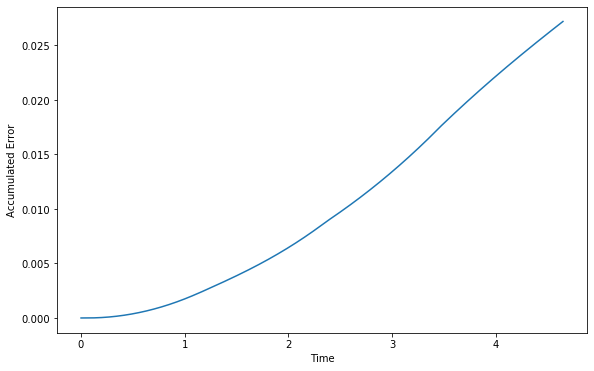

In [319]:
print("Total Distance Traveled: %.2f m" % dist) # display total distance traveled
print("Total Simulation Time: %.2f s" % t)

n = min(len(xi_i), len(xi), len(yi_i), len(yi))
e = [0]
for i in np.arange(n-1):
    e.append(e[i] + np.sum(np.abs(((xi_i[i]-xi[i])**2+(yi_i[i]-yi[i])**2)**0.5))*(dist/n))

print("Total error: %.4f" % e[-1])
z = np.arange(0,t,tinc)[:n]
plt.plot(z,e)
plt.ylabel("Accumulated Error")
plt.xlabel("Time")


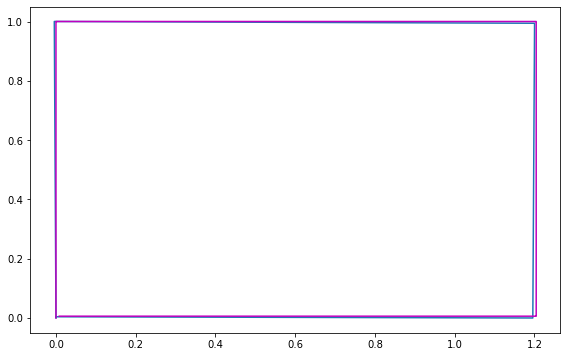

In [303]:
plt.plot(xi,yi) #produces a 2-D plot
plt.plot(xi_i,yi_i,'m')
# axis equal
# xlabel('x')
# ylabel('y')
# title('Path')
# figure
plt.show()

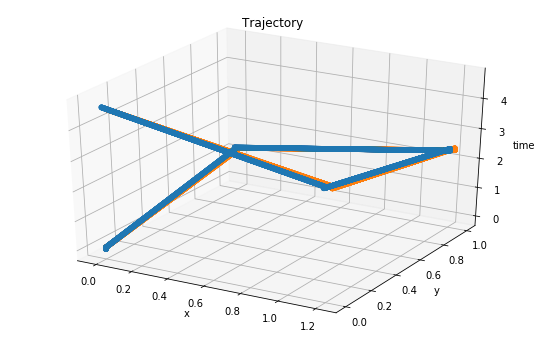

In [273]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
mpld3.disable_notebook()

## TODO make it iteractive

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z=np.arange(0,tmax,tinc)
nn = min(len(xi), len(yi), len(z))
ax.scatter(xi[:nn], yi[:nn], z[:nn]) #produces a 3-D trajectory plot
mm = min(len(xi_i), len(yi_i), len(z))
ax.scatter(xi_i[:mm], yi_i[:mm], z[:mm], 'm') #produces a 3-D trajectory plot
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('time')
ax.set_title('Trajectory')
plt.show()

## Oval trajectory

Reset simulator and run the Oval trajectory.

In [375]:
theta = [0] # inital value of theta (angle between global & local coord sys.)
xi = [0] # initial value of global x for center of robot
yi = [0] # initial value of global y for center of robot
xi_i = [0] # initial value of global x for center of robot
yi_i = [0] # initial value of global y for center of robot
k = 0 # initialize the step counter
t = 0 # initialize time
dist = 0 # initialize distance traveled
GoalFlag = 0 # Set this to 1 when goal is reachedr
segment = 0 # Set this to start at the first stage

def wheel_vel():
    global rwv, lwv, mvw, k, yi, theta, xi, GoalFlag, segment
    
    if (k==0):
        segment=1 # initialize
              
    elif segment == 1: 
        if (xi[-1] < 1.2):
            rwv=mwv
            lwv=mwv #move right
            xi_i.append(xi_i[-1]+tinc*mv)
            yi_i.append(yi_i[-1])
        else:
            segment += 1

    elif segment == 2: 
        if (theta[-1] > - np.pi):
            lwv = +mwv
            rwv = lwv*0.5842
        else:
            segment += 1
            
    elif segment == 3: 
        if (xi[-1] > 0):
            rwv=mwv
            lwv=mwv #move left
        else:
            segment += 1
        
    elif segment == 4: 
        if (theta[-1] > -2*np.pi):
            lwv = +mwv #rotate CW, face east
            rwv = lwv*0.5842
        else:
            GoalFlag = 1 #transition to next segment

In [376]:
while ((GoalFlag == 0)  & (t<tmax)):  #stop at goal, or when time is up
    #construct inverse rotation matrix according to Eqn. 3.10
    rthinv=[[np.cos(theta[-1]), -np.sin(theta[-1]), 0],[np.sin(theta[-1]), np.cos(theta[-1]), 0],[0, 0, 1]]
    #modify the following wheel velocities as needed:
    wheel_vel() #call the driver script which yield wheel velocities rwv, lwv
    phi1dot=rwv #instantaneous velocity of right wheel in rad/s
    phi2dot=lwv #instantaneous velocity of left wheel in rad/s
    #compute the differential pose in the local ref. frame:
    xsi_R_dot=[r*phi1dot/2 + r*phi2dot/2, 0, r*phi1dot/2/l - r*phi2dot/2/l]
    xsi_R = xsi_R_dot[0]*tinc #incremental distance traveled in robot coordinates
    dist = dist + xsi_R #total distance traveled (robot's odometer)
    #Use Eqn. 3.9 to compute the differential pose in the global ref. frame:
    xsi_I_dot=np.dot(rthinv,xsi_R_dot)
    k += 1; #increment step counter
    t += tinc; #increment time if using the while loop
    xi.append(xi[-1]+xsi_I_dot[0]*tinc) #new global x position
    yi.append(yi[-1]+xsi_I_dot[1]*tinc) #new global y position
    theta.append(theta[-1]+xsi_I_dot[2]*tinc) #new value of theta

In [377]:
print("Total Distance Traveled: %.2f m" % dist) # display total distance traveled
print("Total Simulation Time: %.2f s" % t)
tsim = t # display total simulation time
# len(xi), len(yi), len(np.arange(0,t,tinc))

Total Distance Traveled: 3.36 m
Total Simulation Time: 3.61 s


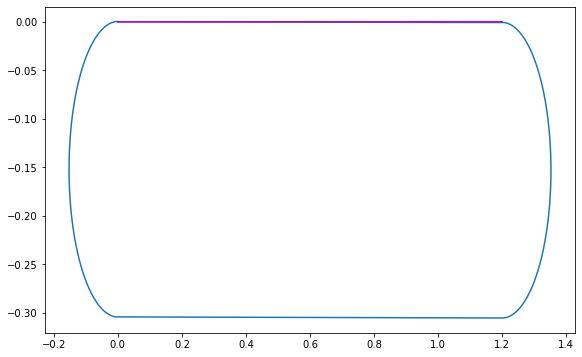

In [378]:
plt.plot(xi,yi) #produces a 2-D plot
plt.plot(xi_i,yi_i,'m')
# axis equal
# xlabel('x')
# ylabel('y')
# title('Path')
# figure
plt.show()

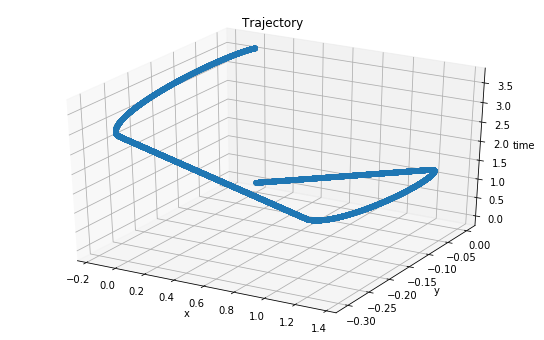

In [379]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
mpld3.disable_notebook()

## TODO make it iteractive

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z=np.arange(0,tmax,tinc)
nn = min(len(xi), len(yi), len(z))
ax.scatter(xi[:nn], yi[:nn], z[:nn]) #produces a 3-D trajectory plot
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('time')
ax.set_title('Trajectory')
plt.show()